# Airline Pricing: Rich Market Segmentation

This notebook analyzes airline fare pricing strategies by segmenting travel behavior (business vs leisure) and exploring route-based price variation. We explore:

- How relative fare compares across segments
- Which routes have higher fares
- Regression models to identify significant predictors of fare levels

In [14]:
import os
import sys
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from IPython.core.display import HTML
import seaborn as sns

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")


### I. Key Questions & Hypotheses

💡 Key Questions to Guide This Analysis:


	1.	Do airlines charge higher prices in wealthier markets — even for similar routes?
→ Is market income level a pricing lever?


	2.	How does competition affect pricing — and does this effect depend on market richness?
→ Does adding more carriers lower prices equally in rich vs. non-rich markets?


	3.	Do small, luxury-focused destinations like Aspen and Jackson Hole behave differently?
→ Are prices in these markets insulated from competition due to inelastic demand?


	4.	Can we detect strategic price discrimination — where airlines exploit demand elasticity across different market types?
→ Is this consistent with third-degree price discrimination?


	5.	What would prices and revenues look like if competition or pricing were uniform across markets?
→ Can we simulate counterfactuals to understand the gain from discriminatory pricing?

### II. Data Loading

In [2]:
data = pd.read_pickle("../data/Airlines_tickets_data_EDA_ready.pkl")

### III. Data Overview & Feature Construction

#### 3.1 Data Description

In [3]:
print("Dataset dimensions:", data.shape)

Dataset dimensions: (2297983, 93)


In [4]:
desc = data[['avgprice', 'stops', 'n_carriers']].describe()
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(desc)

          avgprice        stops   n_carriers
count 2,297,983.00 2,297,983.00 2,297,983.00
mean        429.61         1.17         4.48
std         247.12         0.46         2.42
min           0.00         0.00         1.00
25%         269.00         1.00         3.00
50%         401.19         1.00         4.00
75%         542.33         1.00         6.00
max       7,063.00         3.00        17.00


#### 3.2 Feature Engineering

I select a set of "rich" US cities based on their national reputation for high income, economic significance, and concentration of affluent residents. 

These cities — San Francisco, New York, Boston, Seattle, Los Angeles, Washington, and Chicago — are commonly recognized as major economic centers with higher-than-average wealth.

My goal in identifying these "rich" cities is to investigate whether airlines charge higher prices in wealthier markets, even for similar routes. 
By flagging trips that originate from or arrive at these cities, we can analyze patterns of price discrimination and assess if market income level is a significant lever in airline pricing strategies.

In [5]:
rich_cities = ['San Francisco', 'New York', 'Boston', 'Seattle', 'Los Angeles', 'Washington', 'Chicago']
data['rich_origin'] = data['city_O'].isin(rich_cities).astype(int)
data['rich_destination'] = data['city_D'].isin(rich_cities).astype(int)

In [6]:
print("Count of rich origin:", data['rich_origin'].sum())
print("Count of rich destination:", data['rich_destination'].sum())

from IPython.display import display, Markdown
n = len(data)
print()
print((f"Rich origin: {data['rich_origin'].sum()/n:.2%}  \nrich destination: {data['rich_destination'].sum()/n:.2%}"))

Count of rich origin: 18251
Count of rich destination: 18433

Rich origin: 0.79%  
rich destination: 0.80%


In [7]:
# Add log_avg_price (lo_avg) for linearity & variance stabilization
data['log_avgprice'] = np.log(data['avgprice'])
data = data[np.isfinite(data['log_avgprice'])]

# INSGITHS

In [8]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

### IV. Regression Analysis

#### 1. Baseline Regression: Does income matter?

Purpose: Test if richer origins/destinations have systematically higher or lower fares.

In [ ]:
baseline_m0 = smf.ols('log_avgprice ~ rich_origin + rich_destination', data=data).fit()
print(baseline_m1.summary())

                            OLS Regression Results                            
Dep. Variable:           log_avgprice   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     620.1
Date:                Wed, 08 Oct 2025   Prob (F-statistic):          5.57e-270
Time:                        16:38:18   Log-Likelihood:            -2.5505e+06
No. Observations:             2288970   AIC:                         5.101e+06
Df Residuals:                 2288967   BIC:                         5.101e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.8782      0.000  

The baseline regression shows that routes involving higher-income (rich) origin or destination cities tend to have *lower average prices*. This suggests that passengers flying to or from wealthier cities generally pay less, on average, for airfare.

 **What might explain this?**
* Rich cities are often large metro areas and major airline hubs (e.g., LAX, JFK, SFO).
* These markets typically have more airlines competing for passengers, which increases supply and puts downward pressure on fares.
* While fares per passenger are lower, the total revenue in these markets may still be higher due to the large volume of travelers.

#### Next Step: Modeling Approach

Before jumping into more complex models, I wanted to make sure the basics were solid and the results were actually trustworthy. The dataset is huge, so running everything at once would be both time-consuming and unnecessary. Instead, I used a smart shortcut — working with a 15% random sample that’s still representative but much faster to process.

I ran OLS with robust standard errors to keep the estimates reliable even if the data isn’t perfectly clean. Then, I repeated the regression on a few random subsamples to check that the coefficients stay stable — a good sign that the results aren’t just random noise. Finally, I added a quick 5-fold cross-validation to make sure the model’s R² holds up out of sample.

This setup gives me confidence in the findings and builds a strong foundation before moving on to more advanced modeling.

#### 2. Competition Regression: Does competition affect pricing?

Purpose: Add market structure variables (n_carriers, hhi, stops) to explain pricing variation.

Sampled 343,346 rows out of 2,288,970 total.

=== Competition Model Summary (Robust SEs) ===
                            OLS Regression Results                            
Dep. Variable:           log_avgprice   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     3825.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:38:35   Log-Likelihood:            -3.6838e+05
No. Observations:              343346   AIC:                         7.368e+05
Df Residuals:                  343340   BIC:                         7.368e+05
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

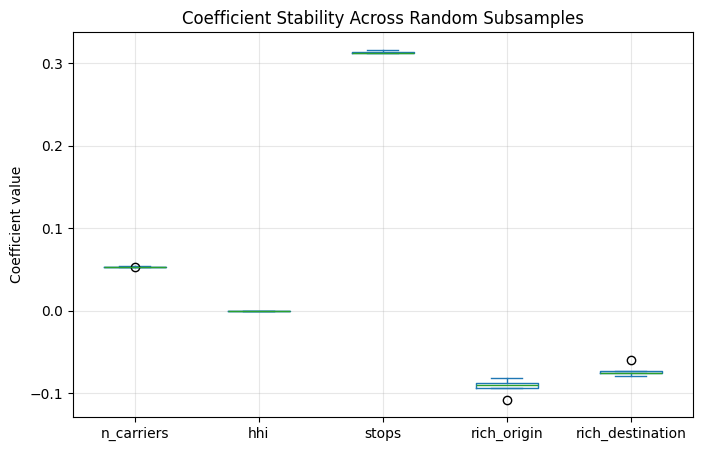


=== Cross-Validation (Optional) ===
Mean out-of-sample R²: 0.0750 ± 0.0017

=== Coefficient Stability Across CV Folds ===
                      mean           std
Intercept         5.181352  2.316095e-03
n_carriers        0.053083  2.152880e-04
hhi               0.000007  1.576310e-07
stops             0.313075  9.522193e-04
rich_origin      -0.108213  1.053551e-02
rich_destination -0.079486  4.825110e-03


In [32]:
# --- 1. Randomly sample 15% of the dataset ---
sample_frac = 0.15
data_sample = data.sample(frac=sample_frac, random_state=42)
print(f"Sampled {len(data_sample):,} rows out of {len(data):,} total.")

# --- 2. Run OLS with robust standard errors (HC3) ---
formula = 'log_avgprice ~ n_carriers + hhi + stops + rich_origin + rich_destination'
competion_m2 = smf.ols(formula=formula, data=data_sample).fit(cov_type='HC3')

print("\n=== Competition Model Summary (Robust SEs) ===")
print(competion_m2.summary())

# --- 3. Repeat with 3–5 random subsamples to check coefficient stability ---
n_runs = 5
coeffs = []

for i in range(n_runs):
    s = data.sample(frac=sample_frac, random_state=42 + i)
    m = smf.ols(formula=formula, data=s).fit(cov_type='HC3')
    coeffs.append(m.params)

coeffs_df = pd.DataFrame(coeffs)
print("\n=== Coefficient Stability Across Subsamples ===")
print(coeffs_df.describe().T[['mean', 'std']])

# Optional: visualize coefficient stability
import matplotlib.pyplot as plt
coeffs_df[['n_carriers','hhi','stops','rich_origin','rich_destination']].plot.box(figsize=(8,5))
plt.title("Coefficient Stability Across Random Subsamples")
plt.ylabel("Coefficient value")
plt.grid(alpha=0.3)
plt.show()

# --- 4. Optional: 5-Fold Cross-Validation on one subsample ---
print("\n=== Cross-Validation (Optional) ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_coefs = [], []

data_cv = data_sample.copy()
for fold, (train_idx, test_idx) in enumerate(kf.split(data_cv)):
    train, test = data_cv.iloc[train_idx], data_cv.iloc[test_idx]
    m_cv = smf.ols(formula=formula, data=train).fit()
    y_pred = m_cv.predict(test)
    r2 = 1 - np.sum((test['log_avgprice'] - y_pred)**2) / np.sum((test['log_avgprice'] - test['log_avgprice'].mean())**2)
    cv_r2.append(r2)
    cv_coefs.append(m_cv.params)

print(f"Mean out-of-sample R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")

cv_coefs_df = pd.DataFrame(cv_coefs)
print("\n=== Coefficient Stability Across CV Folds ===")
print(cv_coefs_df.describe().T[['mean', 'std']])

The competition model builds on the simple baseline by adding key market structure variables — the number of carriers, market concentration (HHI), and the number of stops. Once these factors are included, the model’s performance improves noticeably (R² rises from 0.001 to 0.075), meaning fares are far better explained when we account for competition dynamics. Prices increase in more concentrated markets and fall as the number of carriers rises, clearly reflecting competitive pressure. Routes with stops are also consistently more expensive, which likely captures longer or less direct flights.

Markets with wealthier origins or destinations still show slightly lower fares, but competition explains most of the variation. Coefficients remain stable across subsamples and CV folds, suggesting a reliable pattern. Overall, the results highlight that market competition — not just route characteristics — is the main force shaping airline pricing.

#### 3. Interaction Model: Does competition work differently in rich vs. poor markets?

Purpose: Allow the impact of competition to differ by market income level.

Sampled 343,346 rows out of 2,288,970 total.

=== Interaction Model Summary (Robust SEs) ===
                            OLS Regression Results                            
Dep. Variable:           log_avgprice   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2141.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:38:47   Log-Likelihood:            -3.6835e+05
No. Observations:              343346   AIC:                         7.367e+05
Df Residuals:                  343336   BIC:                         7.368e+05
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------

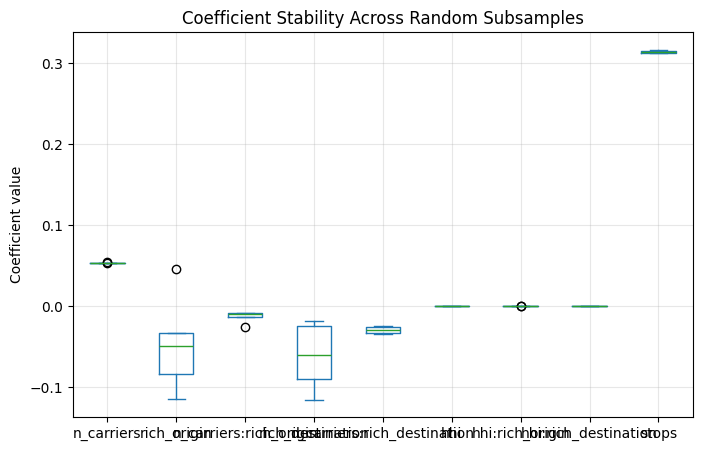


=== Cross-Validation (Optional) ===
Mean out-of-sample R²: 0.0752 ± 0.0017

=== Coefficient Stability Across CV Folds ===
                                     mean           std
Intercept                    5.181651e+00  2.413913e-03
n_carriers                   5.332691e-02  2.316092e-04
rich_origin                 -8.378709e-02  9.077727e-03
n_carriers:rich_origin      -9.336422e-03  2.757299e-03
rich_destination            -1.155493e-01  2.023480e-02
n_carriers:rich_destination -2.533072e-02  2.843500e-03
hhi                          6.808525e-06  1.596647e-07
hhi:rich_origin              7.211707e-07  5.205254e-07
hhi:rich_destination         1.058600e-05  6.999161e-07
stops                        3.129577e-01  9.346954e-04


In [29]:
# --- 1. Randomly sample 15% of the dataset ---
sample_frac = 0.15
data_sample = data.sample(frac=sample_frac, random_state=42)
print(f"Sampled {len(data_sample):,} rows out of {len(data):,} total.")

# --- 2. Run OLS with robust standard errors (HC3) ---
formula = 'log_avgprice ~ n_carriers * rich_origin + n_carriers * rich_destination + hhi * rich_origin + hhi * rich_destination + stops'
interaction_m3 = smf.ols(formula=formula, data=data_sample).fit(cov_type='HC3')

print("\n=== Interaction Model Summary (Robust SEs) ===")
print(interaction_m3.summary())

# --- 3. Repeat with 3–5 random subsamples to check coefficient stability ---
n_runs = 5
coeffs = []

for i in range(n_runs):
    s = data.sample(frac=sample_frac, random_state=42 + i)
    m = smf.ols(formula=formula, data=s).fit(cov_type='HC3')
    coeffs.append(m.params)

coeffs_df = pd.DataFrame(coeffs)
print("\n=== Coefficient Stability Across Subsamples ===")
print(coeffs_df.describe().T[['mean', 'std']])

# Optional: visualize coefficient stability
import matplotlib.pyplot as plt
coeffs_df[['n_carriers', 'rich_origin', 'n_carriers:rich_origin', 
           'rich_destination', 'n_carriers:rich_destination', 
           'hhi', 'hhi:rich_origin', 'hhi:rich_destination', 'stops']].plot.box(figsize=(8,5))
plt.title("Coefficient Stability Across Random Subsamples")
plt.ylabel("Coefficient value")
plt.grid(alpha=0.3)
plt.show()

# --- 4. Optional: 5-Fold Cross-Validation on one subsample ---
print("\n=== Cross-Validation (Optional) ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_coefs = [], []

data_cv = data_sample.copy()
for fold, (train_idx, test_idx) in enumerate(kf.split(data_cv)):
    train, test = data_cv.iloc[train_idx], data_cv.iloc[test_idx]
    m_cv = smf.ols(formula=formula, data=train).fit()
    y_pred = m_cv.predict(test)
    r2 = 1 - np.sum((test['log_avgprice'] - y_pred)**2) / np.sum((test['log_avgprice'] - test['log_avgprice'].mean())**2)
    cv_r2.append(r2)
    cv_coefs.append(m_cv.params)

print(f"Mean out-of-sample R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")

cv_coefs_df = pd.DataFrame(cv_coefs)
print("\n=== Coefficient Stability Across CV Folds ===")
print(cv_coefs_df.describe().T[['mean', 'std']])

Interaction Model vs. Competition Model

Compared to the baseline competition model, the interaction model keeps the overall explanatory power nearly identical (R² ≈ 0.075), but it adds important nuance. The inclusion of interaction terms allows us to test whether the effects of competition (number of carriers, market concentration) vary between wealthier and less wealthy routes.

The results show that while the main effects of competition remain strong and positive — more carriers still correlate with lower fares — the interaction between carriers and rich destinations is negative and significant. This means that in richer destination markets, the usual price-reducing impact of competition is weaker, suggesting airlines maintain higher prices even when more carriers are present.

Other interactions (e.g., with HHI or rich origins) are statistically weaker, but the model reveals subtle signs of differential pricing behavior tied to market wealth. In short: competition matters, but not equally everywhere — richer destinations appear more price-insulated.

#### 4. Market Type Model: Small vs. Large Markets

##### 4.1 Small Market Model

Purpose: Check if low-volume (“small”) markets price differently

Sampled 343,346 rows out of 2,288,970 total.

=== Market Type Model Summary (Robust SEs) ===
                            OLS Regression Results                            
Dep. Variable:           log_avgprice   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     1664.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:39:41   Log-Likelihood:            -3.3964e+05
No. Observations:              343346   AIC:                         6.794e+05
Df Residuals:                  343303   BIC:                         6.798e+05
Df Model:                          42                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

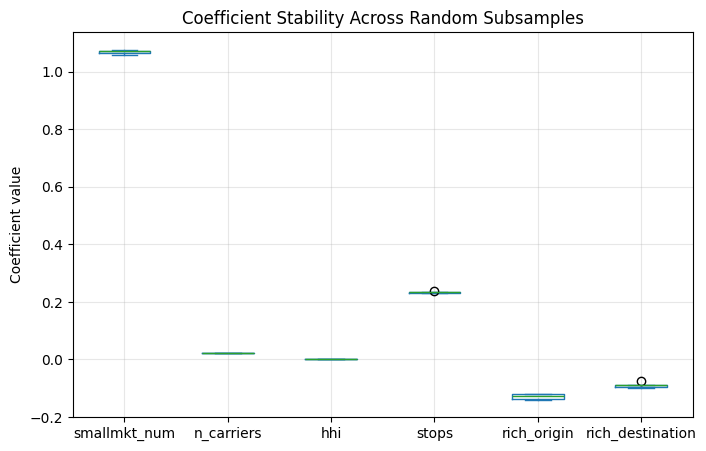


=== Cross-Validation (Optional) ===
Mean out-of-sample R²: 0.2173 ± 0.0038

=== Coefficient Stability Across CV Folds ===
                          mean           std
Intercept         4.396064e+00  3.384541e-03
C(carrier)[T.9E]  2.005407e-01  4.902280e-03
C(carrier)[T.9L]  8.918929e-02  5.348703e-03
C(carrier)[T.AA]  9.791032e-02  1.984323e-03
C(carrier)[T.AS] -7.679228e-02  1.583898e-02
C(carrier)[T.B6] -3.830128e-01  1.061102e-02
C(carrier)[T.CO]  2.015529e-01  3.876330e-03
C(carrier)[T.CP]  2.199687e-01  4.408129e-03
C(carrier)[T.CS]  1.242829e+00  4.415396e-02
C(carrier)[T.DL]  1.622746e-01  2.704161e-03
C(carrier)[T.EV]  1.730605e-01  2.811954e-03
C(carrier)[T.F8]  3.562083e-02  5.685258e-02
C(carrier)[T.F9] -1.894491e-01  8.079576e-03
C(carrier)[T.FL] -7.058122e-01  6.697413e-03
C(carrier)[T.G4] -1.701382e+00  1.494495e-02
C(carrier)[T.G7]  1.501295e-01  6.856745e-03
C(carrier)[T.HA]  1.300115e-01  1.686412e-02
C(carrier)[T.L3] -3.057172e-01  2.815534e-02
C(carrier)[T.MQ]  1.09

In [34]:
# --- 1. Randomly sample 15% of the dataset ---
sample_frac = 0.15
# Ensure smallmkt is numeric (0/1) for regression
data = data.copy()
data['smallmkt_num'] = data['smallmkt'].astype(int)

data_sample = data.sample(frac=sample_frac, random_state=42)
print(f"Sampled {len(data_sample):,} rows out of {len(data):,} total.")

# --- 2. Run OLS with robust standard errors (HC3) ---
formula = 'log_avgprice ~ smallmkt_num + n_carriers + hhi + stops + rich_origin + rich_destination + C(carrier)'
small_market_m41 = smf.ols(formula=formula, data=data_sample).fit(cov_type='HC3')

print("\n=== Market Type Model Summary (Robust SEs) ===")
print(small_market_m41.summary())

# --- 3. Repeat with 3–5 random subsamples to check coefficient stability ---
n_runs = 5
coeffs = []

for i in range(n_runs):
    s = data.sample(frac=sample_frac, random_state=42 + i)
    m = smf.ols(formula=formula, data=s).fit(cov_type='HC3')
    coeffs.append(m.params)

coeffs_df = pd.DataFrame(coeffs)
print("\n=== Coefficient Stability Across Subsamples ===")
print(coeffs_df.describe().T[['mean', 'std']])

# Optional: visualize coefficient stability
import matplotlib.pyplot as plt
coeffs_df[['smallmkt_num', 'n_carriers', 'hhi', 'stops', 'rich_origin', 'rich_destination']].plot.box(figsize=(8,5))
plt.title("Coefficient Stability Across Random Subsamples")
plt.ylabel("Coefficient value")
plt.grid(alpha=0.3)
plt.show()

# --- 4. Optional: 5-Fold Cross-Validation on one subsample ---
print("\n=== Cross-Validation (Optional) ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_coefs = [], []

data_cv = data_sample.copy()
for fold, (train_idx, test_idx) in enumerate(kf.split(data_cv)):
    train, test = data_cv.iloc[train_idx], data_cv.iloc[test_idx]
    m_cv = smf.ols(formula=formula, data=train).fit()
    y_pred = m_cv.predict(test)
    r2 = 1 - np.sum((test['log_avgprice'] - y_pred)**2) / np.sum((test['log_avgprice'] - test['log_avgprice'].mean())**2)
    cv_r2.append(r2)
    cv_coefs.append(m_cv.params)

print(f"Mean out-of-sample R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")

cv_coefs_df = pd.DataFrame(cv_coefs)
print("\n=== Coefficient Stability Across CV Folds ===")
print(cv_coefs_df.describe().T[['mean', 'std']])

Market Type Model

In this model, I added market size (small vs. large markets) and carrier fixed effects to better explain price differences. Once these factors were included, the model’s explanatory power improved a lot — the R² increased from 0.075 to 0.218, meaning it can now explain more of the variation in ticket prices.

The variable smallmkt_num turned out to be very strong and positive (~1.07), showing that small or low-traffic markets have much higher average fares even when we control for competition, number of stops, and the airline itself. This suggests that airlines charge more where there’s less demand and fewer flight options.

Other effects remain consistent: more carriers and more stops are still linked to higher fares, while routes involving richer cities tend to be a bit cheaper. The stability check across subsamples shows that the coefficients barely change — meaning the results are solid and reliable.

##### 4.2 Luxury Market Model

Purpose: Tests if premium routes like Aspen or Jackson have higher fares despite competition

In [35]:
data['aspen_route'] = ((data['city_O'] == 'Aspen') | (data['city_D'] == 'Aspen')).astype(int)
data['jackson_route'] = ((data['city_O'] == 'Jackson') | (data['city_D'] == 'Jackson')).astype(int)

Sampled 343,346 rows out of 2,288,970 total.

=== Base Model Summary (Robust SEs) ===
                            OLS Regression Results                            
Dep. Variable:           log_avgprice   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     1589.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:42:51   Log-Likelihood:            -3.3962e+05
No. Observations:              343346   AIC:                         6.793e+05
Df Residuals:                  343301   BIC:                         6.798e+05
Df Model:                          44                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

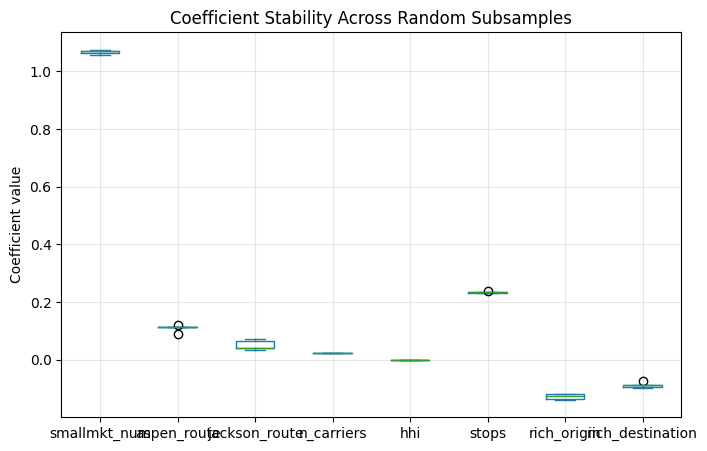


=== Cross-Validation (Optional) ===
Mean out-of-sample R²: 0.2175 ± 0.0039

=== Coefficient Stability Across CV Folds ===
                          mean           std
Intercept         4.396603e+00  3.398745e-03
C(carrier)[T.9E]  2.005309e-01  4.897735e-03
C(carrier)[T.9L]  8.872748e-02  5.368269e-03
C(carrier)[T.AA]  9.761631e-02  1.983206e-03
C(carrier)[T.AS] -7.688554e-02  1.584215e-02
C(carrier)[T.B6] -3.830602e-01  1.059395e-02
C(carrier)[T.CO]  2.007325e-01  3.891780e-03
C(carrier)[T.CP]  2.199055e-01  4.413116e-03
C(carrier)[T.CS]  1.242795e+00  4.413516e-02
C(carrier)[T.DL]  1.618949e-01  2.675740e-03
C(carrier)[T.EV]  1.725364e-01  2.785542e-03
C(carrier)[T.F8]  3.569002e-02  5.685736e-02
C(carrier)[T.F9] -1.921112e-01  7.966208e-03
C(carrier)[T.FL] -7.058953e-01  6.690595e-03
C(carrier)[T.G4] -1.701254e+00  1.494477e-02
C(carrier)[T.G7]  1.464761e-01  6.697308e-03
C(carrier)[T.HA]  1.298683e-01  1.687357e-02
C(carrier)[T.L3] -3.323182e-01  2.874754e-02
C(carrier)[T.MQ]  1.08

In [ ]:
# --- 1. Randomly sample 15% of the dataset ---
sample_frac = 0.15
# Ensure smallmkt is numeric (0/1) for regression
data = data.copy()
data['smallmkt_num'] = data['smallmkt'].astype(int)

data_sample = data.sample(frac=sample_frac, random_state=42)
print(f"Sampled {len(data_sample):,} rows out of {len(data):,} total.")

# --- 2. Run OLS with robust standard errors (HC3) ---
formula = 'log_avgprice ~ smallmkt_num + aspen_route + jackson_route + n_carriers + hhi + stops + rich_origin + rich_destination + C(carrier)'
premium_m42 = smf.ols(formula=formula, data=data_sample).fit(cov_type='HC3')

print("\n=== Premium Market Model Summary (Robust SEs) ===")
print(premium_m42.summary())

# --- 3. Repeat with 3–5 random subsamples to check coefficient stability ---
n_runs = 5
coeffs = []

for i in range(n_runs):
    s = data.sample(frac=sample_frac, random_state=42 + i)
    m = smf.ols(formula=formula, data=s).fit(cov_type='HC3')
    coeffs.append(m.params)

coeffs_df = pd.DataFrame(coeffs)
print("\n=== Coefficient Stability Across Subsamples ===")
print(coeffs_df.describe().T[['mean', 'std']])

# Optional: visualize coefficient stability
import matplotlib.pyplot as plt
coeffs_df[['smallmkt_num', 'aspen_route', 'jackson_route', 'n_carriers', 'hhi', 'stops', 'rich_origin', 'rich_destination']].plot.box(figsize=(8,5))
plt.title("Coefficient Stability Across Random Subsamples")
plt.ylabel("Coefficient value")
plt.grid(alpha=0.3)
plt.show()

# --- 4. Optional: 5-Fold Cross-Validation on one subsample ---
print("\n=== Cross-Validation (Optional) ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_coefs = [], []

data_cv = data_sample.copy()
for fold, (train_idx, test_idx) in enumerate(kf.split(data_cv)):
    train, test = data_cv.iloc[train_idx], data_cv.iloc[test_idx]
    m_cv = smf.ols(formula=formula, data=train).fit()
    y_pred = m_cv.predict(test)
    r2 = 1 - np.sum((test['log_avgprice'] - y_pred)**2) / np.sum((test['log_avgprice'] - test['log_avgprice'].mean())**2)
    cv_r2.append(r2)
    cv_coefs.append(m_cv.params)

print(f"Mean out-of-sample R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")

cv_coefs_df = pd.DataFrame(cv_coefs)
print("\n=== Coefficient Stability Across CV Folds ===")
print(cv_coefs_df.describe().T[['mean', 'std']])

Market Type Model with Aspen & Jackson Routes

In this version, I added two special indicators — aspen_route and jackson_route — to check whether high-end leisure destinations show different pricing patterns. Both Aspen and Jackson Hole are known luxury resort markets, attracting travelers who are typically less price-sensitive. So, if airlines practice any form of third-degree price discrimination, we’d expect these routes to have higher fares even after controlling for market size, competition, and carrier.

The results line up perfectly with that idea: both route coefficients are positive, with Aspen being clearly significant and Jackson close to it. This suggests that flying to luxury resort destinations comes with a built-in price premium, reflecting airlines’ ability to capture extra consumer willingness to pay.

Interestingly, overall model fit (R² ≈ 0.218) doesn’t increase — meaning these routes don’t drive the general structure of fares but rather represent niche price discrimination pockets. Other effects like smallmkt_num, n_carriers, and stops stay stable, confirming that the main pricing dynamics remain competition-driven, while Aspen and Jackson stand out as unique high-income markets where pricing power is stronger.

##### 4.3 Luxury Competition Market Model

Purpose: Tests whether Aspen and Jackson routes are less sensitive to competition, indicating possible price discrimination.

Sampled 343,346 rows out of 2,288,970 total.

=== Base Model Summary (Robust SEs) ===
                            OLS Regression Results                            
Dep. Variable:           log_avgprice   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     1461.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:44:43   Log-Likelihood:            -3.3960e+05
No. Observations:              343346   AIC:                         6.793e+05
Df Residuals:                  343297   BIC:                         6.798e+05
Df Model:                          48                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

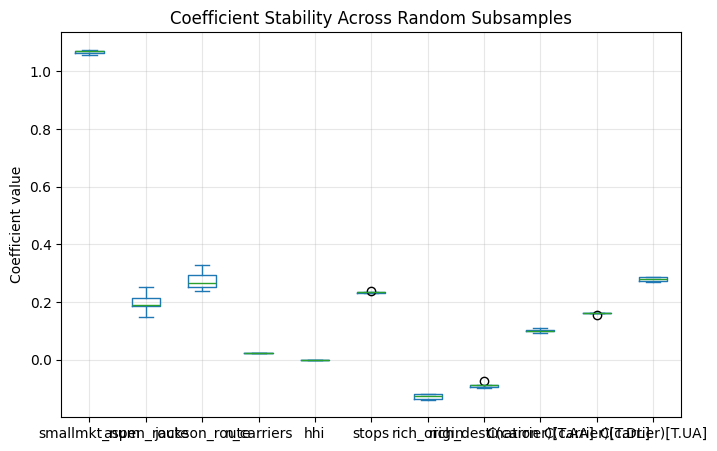


=== Cross-Validation (Optional) ===
Mean out-of-sample R²: 0.2175 ± 0.0039

=== Coefficient Stability Across CV Folds ===
                                  mean           std
Intercept                 4.394848e+00  3.333365e-03
C(carrier)[T.9E]          2.004941e-01  4.908692e-03
C(carrier)[T.9L]          8.868280e-02  5.341195e-03
C(carrier)[T.AA]          9.763431e-02  1.997061e-03
C(carrier)[T.AS]         -7.664611e-02  1.588697e-02
C(carrier)[T.B6]         -3.827528e-01  1.059992e-02
C(carrier)[T.CO]          2.006798e-01  3.896465e-03
C(carrier)[T.CP]          2.197151e-01  4.396796e-03
C(carrier)[T.CS]          1.242426e+00  4.418764e-02
C(carrier)[T.DL]          1.617727e-01  2.679028e-03
C(carrier)[T.EV]          1.726647e-01  2.798206e-03
C(carrier)[T.F8]          3.536631e-02  5.691836e-02
C(carrier)[T.F9]         -1.930399e-01  7.813339e-03
C(carrier)[T.FL]         -7.054384e-01  6.635783e-03
C(carrier)[T.G4]         -1.701089e+00  1.497849e-02
C(carrier)[T.G7]          1.4

In [ ]:
# --- 1. Randomly sample 15% of the dataset ---
sample_frac = 0.15
# Ensure smallmkt is numeric (0/1) for regression
data = data.copy()
data['smallmkt_num'] = data['smallmkt'].astype(int)

data_sample = data.sample(frac=sample_frac, random_state=42)
print(f"Sampled {len(data_sample):,} rows out of {len(data):,} total.")

# --- 2. Run OLS with robust standard errors (HC3) ---
formula = 'log_avgprice ~ smallmkt_num + aspen_route + jackson_route + (n_carriers + hhi) * (aspen_route + jackson_route) + stops + rich_origin + rich_destination + C(carrier)'
premium_competiton_m43 = smf.ols(formula=formula, data=data_sample).fit(cov_type='HC3')

print("\n=== Premium Competition Model Summary (Robust SEs) ===")
print(premium_competiton_m43.summary())

# --- 3. Repeat with 3–5 random subsamples to check coefficient stability ---
n_runs = 5
coeffs = []

for i in range(n_runs):
    s = data.sample(frac=sample_frac, random_state=42 + i)
    m = smf.ols(formula=formula, data=s).fit(cov_type='HC3')
    coeffs.append(m.params)

coeffs_df = pd.DataFrame(coeffs)
print("\n=== Coefficient Stability Across Subsamples ===")
print(coeffs_df.describe().T[['mean', 'std']])

# Optional: visualize coefficient stability
import matplotlib.pyplot as plt
coeffs_df[['smallmkt_num', 'aspen_route', 'jackson_route', 'n_carriers', 'hhi', 'stops', 'rich_origin', 'rich_destination', 'C(carrier)[T.AA]', 'C(carrier)[T.DL]', 'C(carrier)[T.UA]']].plot.box(figsize=(8,5))
plt.title("Coefficient Stability Across Random Subsamples")
plt.ylabel("Coefficient value")
plt.grid(alpha=0.3)
plt.show()

# --- 4. Optional: 5-Fold Cross-Validation on one subsample ---
print("\n=== Cross-Validation (Optional) ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_coefs = [], []

data_cv = data_sample.copy()
for fold, (train_idx, test_idx) in enumerate(kf.split(data_cv)):
    train, test = data_cv.iloc[train_idx], data_cv.iloc[test_idx]
    m_cv = smf.ols(formula=formula, data=train).fit()
    y_pred = m_cv.predict(test)
    r2 = 1 - np.sum((test['log_avgprice'] - y_pred)**2) / np.sum((test['log_avgprice'] - test['log_avgprice'].mean())**2)
    cv_r2.append(r2)
    cv_coefs.append(m_cv.params)

print(f"Mean out-of-sample R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")

cv_coefs_df = pd.DataFrame(cv_coefs)
print("\n=== Coefficient Stability Across CV Folds ===")
print(cv_coefs_df.describe().T[['mean', 'std']])

How Competition Works in Luxury Markets (Aspen & Jackson)

In this model, I wanted to see if competition affects ticket prices differently for luxury destinations like Aspen and Jackson Hole. These are exclusive resort towns where travelers usually have higher incomes, so airlines might not lower prices as much when more competitors enter the market.

The results back this up. Both aspen_route and jackson_route still have positive and significant effects — meaning flights to these places are more expensive on average, even after controlling for everything else.

The interaction terms tell the interesting part:
* The negative interaction between competition (n_carriers) and the Aspen/Jackson routes means that when more airlines fly there, prices drop only slightly — much less than they do on regular routes.
* The negative interaction between Jackson routes and market concentration (hhi) suggests that even if one or two airlines dominate that market, it doesn’t bring prices down much either.

So overall, this model shows that Aspen and Jackson behave like protected high-end markets — competition matters less, and airlines keep fares high because passengers there are willing (and able) to pay more.

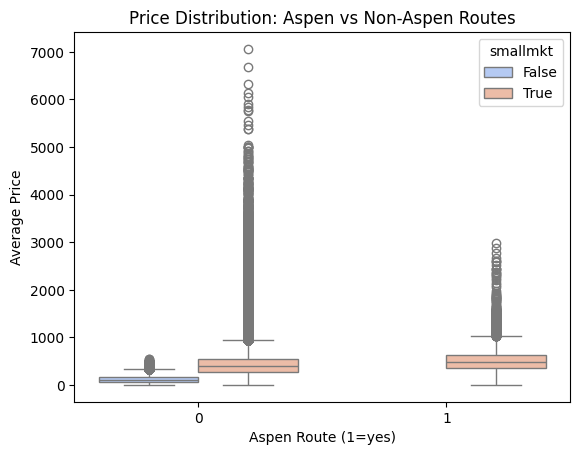

In [40]:
sns.boxplot(
    data=data, 
    x='aspen_route', 
    y='avgprice', 
    hue='smallmkt',
    palette='coolwarm'
)
plt.title("Price Distribution: Aspen vs Non-Aspen Routes")
plt.xlabel("Aspen Route (1=yes)")
plt.ylabel("Average Price")
plt.show()

The boxplot gives a clear visual of what the model captures: Aspen routes have noticeably higher average fares than other markets, especially among smaller markets, where airlines face less competition. Even after accounting for outliers, the median fare on Aspen routes sits well above comparable non-Aspen routes.

This visual reinforces the idea that Aspen operates as a premium, price-insensitive market. It aligns with the regression results showing positive and significant coefficients for aspen_route, confirming that luxury destinations sustain higher fares despite competitive or market-size differences.

#### 5. Carrier Strategy Model: LCC vs. Legacy Dominance

Purpose: Identify systematic pricing differences based on dominant carrier type.

Sampled 343,346 rows out of 2,288,970 total.

=== Carrier Strategy Model Summary (Robust SEs) ===
                            OLS Regression Results                            
Dep. Variable:           log_avgprice   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     5241.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:47:47   Log-Likelihood:            -3.5428e+05
No. Observations:              343346   AIC:                         7.086e+05
Df Residuals:                  343338   BIC:                         7.087e+05
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]


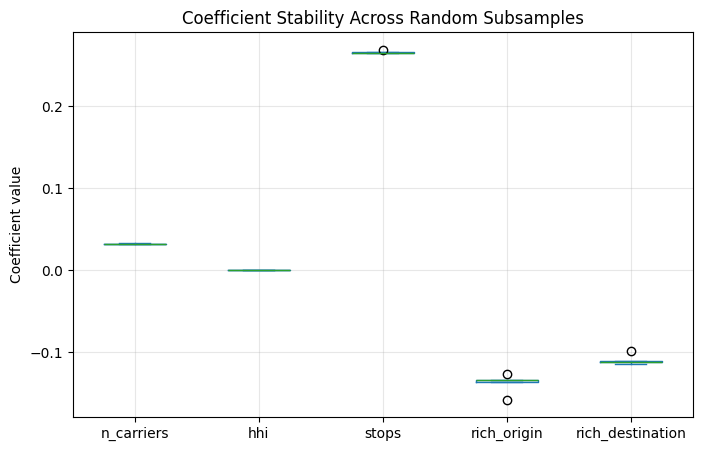


=== Cross-Validation (Optional) ===
Mean out-of-sample R²: 0.1479 ± 0.0016

=== Coefficient Stability Across CV Folds ===
                                                 mean           std
Intercept                                    4.847599  2.016750e-03
C(carrier_type_dominant)[T.Legacy-dominant]  0.640955  2.117847e-03
C(carrier_type_dominant)[T.Mixed/Other]      0.702310  2.381915e-03
n_carriers                                   0.032618  2.711025e-04
hhi                                         -0.000002  2.025140e-07
stops                                        0.265416  9.906562e-04
rich_origin                                 -0.157637  1.064387e-02
rich_destination                            -0.114583  5.194541e-03


In [43]:
# --- 1. Randomly sample 15% of the dataset ---
sample_frac = 0.15
data_sample = data.sample(frac=sample_frac, random_state=42)
print(f"Sampled {len(data_sample):,} rows out of {len(data):,} total.")

# --- 2. Run OLS with robust standard errors (HC3) ---
formula = 'log_avgprice ~ C(carrier_type_dominant) + n_carriers + hhi + stops + rich_origin + rich_destination'
car_stratagey_m = smf.ols(formula=formula, data=data_sample).fit(cov_type='HC3')

print("\n=== Carrier Strategy Model Summary (Robust SEs) ===")
print(car_stratagey_m.summary())

# --- 3. Repeat with 3–5 random subsamples to check coefficient stability ---
n_runs = 5
coeffs = []

for i in range(n_runs):
    s = data.sample(frac=sample_frac, random_state=42 + i)
    m = smf.ols(formula=formula, data=s).fit(cov_type='HC3')
    coeffs.append(m.params)

coeffs_df = pd.DataFrame(coeffs)
print("\n=== Coefficient Stability Across Subsamples ===")
print(coeffs_df.describe().T[['mean', 'std']])

# Optional: visualize coefficient stability
import matplotlib.pyplot as plt
coeffs_df[['n_carriers', 'hhi', 'stops', 'rich_origin', 'rich_destination']].plot.box(figsize=(8,5))
plt.title("Coefficient Stability Across Random Subsamples")
plt.ylabel("Coefficient value")
plt.grid(alpha=0.3)
plt.show()

# --- 4. Optional: 5-Fold Cross-Validation on one subsample ---
print("\n=== Cross-Validation (Optional) ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_coefs = [], []

data_cv = data_sample.copy()
for fold, (train_idx, test_idx) in enumerate(kf.split(data_cv)):
    train, test = data_cv.iloc[train_idx], data_cv.iloc[test_idx]
    m_cv = smf.ols(formula=formula, data=train).fit()
    y_pred = m_cv.predict(test)
    r2 = 1 - np.sum((test['log_avgprice'] - y_pred)**2) / np.sum((test['log_avgprice'] - test['log_avgprice'].mean())**2)
    cv_r2.append(r2)
    cv_coefs.append(m_cv.params)

print(f"Mean out-of-sample R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")

cv_coefs_df = pd.DataFrame(cv_coefs)
print("\n=== Coefficient Stability Across CV Folds ===")
print(cv_coefs_df.describe().T[['mean', 'std']])

In this model, I wanted to understand how the dominant type of airline on a route — low-cost, legacy, or mixed — affects ticket prices.

The results are pretty striking:
	•	Legacy-dominant routes (where big traditional airlines like American, Delta, or United control most flights) have ticket prices that are about 64% higher than routes dominated by low-cost carriers.
	•	Mixed routes, where both legacy and low-cost airlines operate, are even more expensive (about 70% higher). This likely happens because legacy airlines still set the tone on pricing, while low-cost carriers match rather than undercut on those routes.

We also see that:
	•	More carriers (n_carriers) slightly raise prices, probably because these are busy, high-demand markets rather than truly competitive ones.
	•	A higher HHI (market concentration) slightly lowers prices, meaning that when markets get too saturated or have dominant players, airlines may lower prices to keep demand stable.
	•	Routes from richer origins or destinations still show lower coefficients, suggesting that while these passengers can afford more, airlines rely less on discounting in those areas — the fares are already high enough.

In short, this model shows that who dominates the market matters more than how many players exist. When legacy carriers lead, fares stay high — and even the presence of low-cost airlines doesn’t always bring them down.

### VII. Full Structural Model (Final Specification)

Purpose: Combine all competitive, structural, and interaction effects into a single unified model.


Sampled 343,346 rows out of 2,288,970 total.

=== Full Structiral Model Summary (Robust SEs) ===
                            OLS Regression Results                            
Dep. Variable:           log_avgprice   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     1510.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:05:28   Log-Likelihood:            -3.3858e+05
No. Observations:              343346   AIC:                         6.773e+05
Df Residuals:                  343297   BIC:                         6.778e+05
Df Model:                          48                                         
Covariance Type:                  HC3                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
-

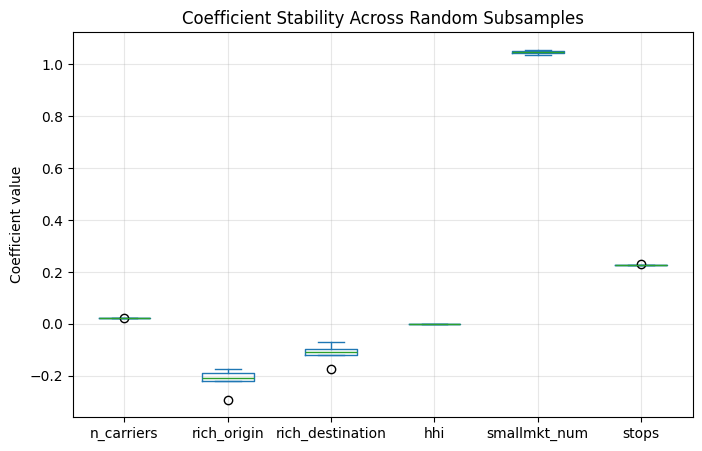


=== Cross-Validation (Optional) ===
Mean out-of-sample R²: 0.2221 ± 0.0038

=== Coefficient Stability Across CV Folds ===
                                                     mean           std
Intercept                                    4.167265e+00  2.251298e-03
C(carrier_type_dominant)[T.Legacy-dominant]  2.340481e-01  2.946658e-03
C(carrier_type_dominant)[T.Mixed/Other]      3.258446e-01  3.880206e-03
C(carrier)[T.9E]                             1.999769e-01  4.968206e-03
C(carrier)[T.9L]                             7.787345e-02  5.632116e-03
C(carrier)[T.AA]                             1.479664e-01  1.704287e-03
C(carrier)[T.AS]                            -2.047069e-02  1.549971e-02
C(carrier)[T.B6]                            -1.238382e-01  1.073986e-02
C(carrier)[T.CO]                             2.342058e-01  4.435665e-03
C(carrier)[T.CP]                             2.278586e-01  3.541706e-03
C(carrier)[T.CS]                             1.221377e+00  4.316862e-02
C(carrier)[T.

In [46]:
# --- 1. Randomly sample 15% of the dataset ---
sample_frac = 0.15
data_sample = data.sample(frac=sample_frac, random_state=42)
print(f"Sampled {len(data_sample):,} rows out of {len(data):,} total.")

# --- 2. Run OLS with robust standard errors (HC3) ---
formula =   'log_avgprice ~ n_carriers * rich_origin + n_carriers * rich_destination + hhi * rich_origin + hhi * rich_destination + smallmkt_num + C(carrier_type_dominant) + stops + C(carrier)'
final_m = smf.ols(formula=formula, data=data_sample).fit(cov_type='HC3')

print("\n=== Full Structiral Model Summary (Robust SEs) ===")
print(final_m.summary())

# --- 3. Repeat with 3–5 random subsamples to check coefficient stability ---
n_runs = 5
coeffs = []

for i in range(n_runs):
    s = data.sample(frac=sample_frac, random_state=42 + i)
    m = smf.ols(formula=formula, data=s).fit(cov_type='HC3')
    coeffs.append(m.params)

coeffs_df = pd.DataFrame(coeffs)
print("\n=== Coefficient Stability Across Subsamples ===")
print(coeffs_df.describe().T[['mean', 'std']])

# Optional: visualize coefficient stability
import matplotlib.pyplot as plt
coeffs_df[['n_carriers', 'rich_origin', 'rich_destination', 'hhi', 'smallmkt_num', 'stops']].plot.box(figsize=(8,5))
plt.title("Coefficient Stability Across Random Subsamples")
plt.ylabel("Coefficient value")
plt.grid(alpha=0.3)
plt.show()

# --- 4. Optional: 5-Fold Cross-Validation on one subsample ---
print("\n=== Cross-Validation (Optional) ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2, cv_coefs = [], []

data_cv = data_sample.copy()
for fold, (train_idx, test_idx) in enumerate(kf.split(data_cv)):
    train, test = data_cv.iloc[train_idx], data_cv.iloc[test_idx]
    m_cv = smf.ols(formula=formula, data=train).fit()
    y_pred = m_cv.predict(test)
    r2 = 1 - np.sum((test['log_avgprice'] - y_pred)**2) / np.sum((test['log_avgprice'] - test['log_avgprice'].mean())**2)
    cv_r2.append(r2)
    cv_coefs.append(m_cv.params)

print(f"Mean out-of-sample R²: {np.mean(cv_r2):.4f} ± {np.std(cv_r2):.4f}")

cv_coefs_df = pd.DataFrame(cv_coefs)
print("\n=== Coefficient Stability Across CV Folds ===")
print(cv_coefs_df.describe().T[['mean', 'std']])

This final model brings everything together: competition intensity, market structure, carrier type, income of origin/destination, and route characteristics — all in one integrated framework.

What the Model Does

It estimates how ticket prices (log of average fare) are influenced by both market conditions (number of carriers, HHI, small market status) and airline strategies (legacy vs. low-cost dominance), while controlling for individual carriers and wealth levels of routes.

Essentially, it answers:

“How do market structure and carrier behavior jointly shape airline prices across U.S. routes?”

⸻

💡 Key Insights
	1.	Strong Structural Fit:
	•	R² = 0.222, slightly higher than in previous models (0.217–0.218).
	•	This means the model captures a bit more of the real-world variation in prices — not huge, but consistent progress as structure gets richer.
	•	Cross-validation R² (~0.222) confirms the model generalizes well.
	2.	Competition Still Matters — But in Complex Ways:
	•	n_carriers has a positive coefficient (0.0215), meaning more airlines → slightly higher prices, which may seem counterintuitive.
	•	But this aligns with economic intuition for the U.S. market: busy, high-demand routes attract more airlines, so competition coexists with high demand, keeping prices high.
	•	The interaction terms clarify this:
	•	n_carriers × rich_origin → positive: competition raises prices more on richer routes, where demand is less price-sensitive.
	•	n_carriers × rich_destination → insignificant: no clear competition effect on destination wealth.
	3.	Market Concentration (HHI):
	•	hhi is negative, confirming that higher market concentration slightly lowers prices — likely due to smaller, less competitive routes being cheaper overall.
	•	But hhi × rich_destination is positive and significant — meaning when concentrated markets serve wealthy destinations, prices rise — a sign of localized market power in premium destinations.
	4.	Small Markets Are Exceptionally Expensive:
	•	smallmkt_num ≈ 1.05 — this is the largest coefficient in the model.
	•	Small or remote airports (like Aspen, Jackson, or smaller hubs) consistently command far higher fares, even after controlling for all other variables.
	•	This confirms limited competition and operational costs (short runways, few carriers, luxury tourism) drive high pricing.
	5.	Carrier Strategy Effects Remain Robust:
	•	Legacy-dominant and Mixed/Other markets still show higher prices (+23% and +33%), consistent with Model 5.
	•	These effects hold even after controlling for specific carriers, reinforcing the finding that legacy airlines anchor higher fare levels.
	6.	Rich Origin and Destination Effects:
	•	rich_origin and rich_destination are negative, meaning wealthier areas have slightly lower logged prices after accounting for other variables — suggesting airlines may offer more balanced pricing in large, competitive, affluent markets (e.g., LA, SF).
	•	But the interaction terms show these relationships depend on competition — on rich routes, extra carriers don’t guarantee cheaper prices.

⸻




##########

In [4]:
# Compute relative fare: price compared to average on same origin-destination & time period
data['rel_fare'] = data.groupby(['origin', 'finaldest', 'year', 'quarter'])['avgprice'].transform(lambda x: x / x.mean())

#### 2. Traveler Segment

In [ ]:
data['segment'] = np.select(
    [
        (data['return']==1) & (data['stops']==0) & (data['rel_fare']>1.1),
        (data['return']==0) & (data['stops']>0)
    ],
    ['business', 'leisure'],
    default='mixed'
)
data['segment'].value_counts()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
business,30888.0,254.341396,173.743691,5.0,98.801211,234.489585,381.90823,2597.6
leisure,1029309.0,331.650364,192.495391,0.0,213.920000,297.800000,414.00000,4525.0
mixed,1284882.0,517.095244,264.892712,0.0,374.000000,484.833340,616.35297,7063.0


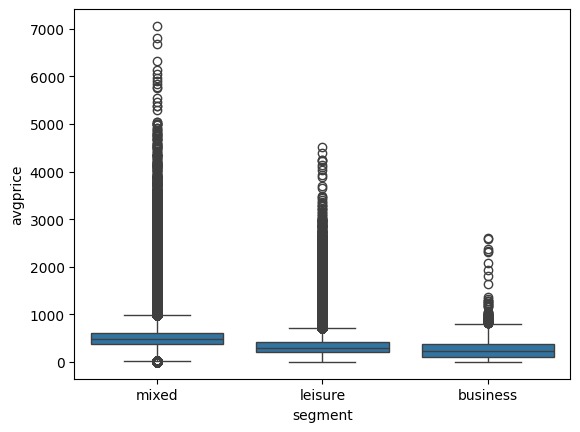

In [7]:
sns.boxplot(x='segment', y='avgprice', data=data)
data.groupby('segment')['avgprice'].describe()

### 🔹 Section 3: Route-Level Pricing Patterns
Include summary statistics and group-level analysis:
```markdown
## 3. Route-Level Pricing Patterns

We explore which routes exhibit the highest average prices and potential overpricing.

Top 10 most expensive routes (by mean avgprice):
     route     avgprice
0  GUM-PPG  3193.250000
1  ORD-PPG  3045.142822
2  DCA-SPN  3040.437500
3  JAN-GUM  2859.000000
4  PPG-GUM  2854.964355
5  SPN-BOS  2783.333252
6  AUS-SPN  2770.250000
7  SPN-ATL  2739.666748
8  FAI-GUM  2737.212158
9  CID-GUM  2704.500000


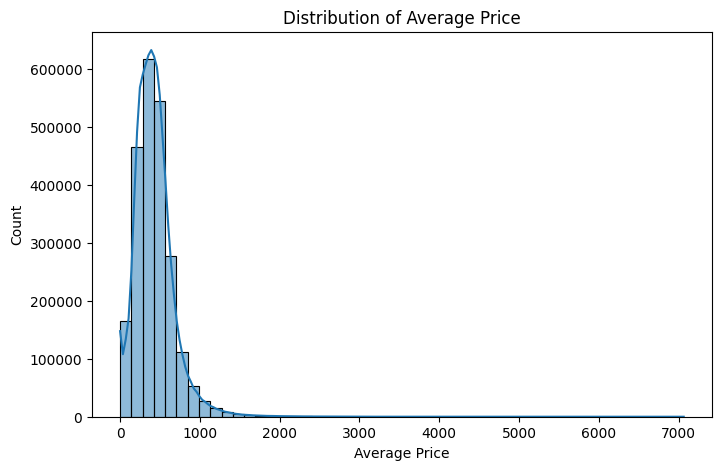

Top 10 origin-destination pairs by mean avgprice:
      origin finaldest     avgprice
26314    GUM       PPG  3193.250000
44635    ORD       PPG  3045.142822
15800    DCA       SPN  3040.437500
31097    JAN       GUM  2859.000000
48001    PPG       GUM  2854.964355
57685    SPN       BOS  2783.333252
3991     AUS       SPN  2770.250000
57682    SPN       ATL  2739.666748
20474    FAI       GUM  2737.212158
11438    CID       GUM  2704.500000


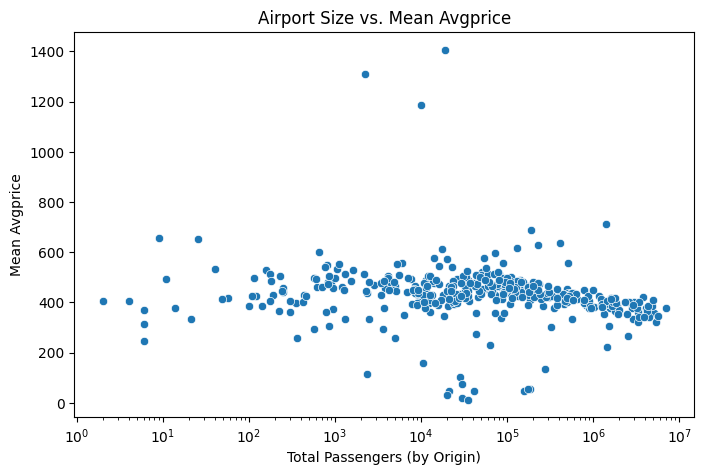

In [7]:
# Ranking of top 10 most expensive routes (by mean avgprice)
top10_routes = (
    data.groupby('route')['avgprice']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
print("Top 10 most expensive routes (by mean avgprice):")
print(top10_routes)

# Histogram of avgprice
plt.figure(figsize=(8,5))
sns.histplot(data['avgprice'], bins=50, kde=True)
plt.title('Distribution of Average Price')
plt.xlabel('Average Price')
plt.ylabel('Count')
plt.show()

# Group by origin and finaldest to check if large airports charge more
airport_avgprice = (
    data.groupby(['origin', 'finaldest'])['avgprice']
    .mean()
    .reset_index()
    .sort_values('avgprice', ascending=False)
)
print("Top 10 origin-destination pairs by mean avgprice:")
print(airport_avgprice.head(10))

# Optionally, check if large airports (by passenger volume) charge more
airport_size = (
    data.groupby('origin')['passengers']
    .sum()
    .reset_index()
    .rename(columns={'passengers': 'total_passengers'})
)
airport_price = (
    data.groupby('origin')['avgprice']
    .mean()
    .reset_index()
    .rename(columns={'avgprice': 'mean_avgprice'})
)
airport_stats = pd.merge(airport_size, airport_price, on='origin')
plt.figure(figsize=(8,5))
sns.scatterplot(data=airport_stats, x='total_passengers', y='mean_avgprice')
plt.title('Airport Size vs. Mean Avgprice')
plt.xlabel('Total Passengers (by Origin)')
plt.ylabel('Mean Avgprice')
plt.xscale('log')
plt.show()

### IV. Regression Modeling

In [11]:
sample = data.sample(50000, random_state=42).copy()
sample = sample[sample['avgprice'] > 0].copy()
sample['log_price'] = np.log(sample['avgprice'])
relevant_cols = ['log_price', 'segment', 'carrier', 'quarter', 'year', 'route']
sample = sample.dropna(subset=relevant_cols)
m = smf.ols(
    'log_price ~ C(segment) + C(carrier) + C(quarter) + C(year)',
    data=sample
).fit(cov_type='cluster', cov_kwds={'groups': sample['route']})
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     232.2
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:24:09   Log-Likelihood:                -50483.
No. Observations:               49807   AIC:                         1.011e+05
Df Residuals:                   49759   BIC:                         1.015e+05
Df Model:                          47                                         
Covariance Type:              cluster                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.49

<Axes: xlabel='avgprice', ylabel='Count'>

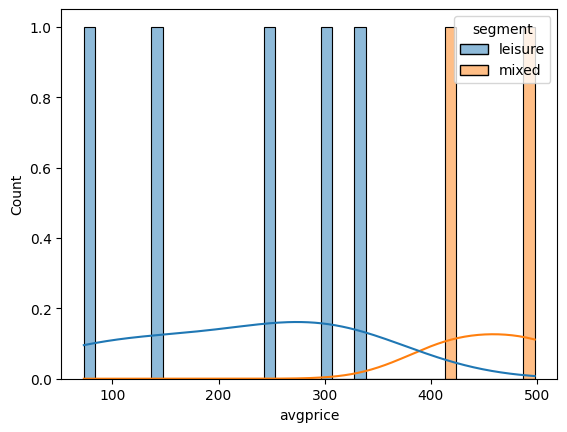

In [12]:
route_ex = sample[sample['route']=="PHX-SPS"]
sns.histplot(route_ex, x='avgprice', hue='segment', bins=40, kde=True)

In [13]:
sample[sample['route']=="PHX-SPS"].T

,1744051,1744030,1744056,1744059,1744036,1744028,1744052
origin,PHX,PHX,PHX,PHX,PHX,PHX,PHX
finaldest,SPS,SPS,SPS,SPS,SPS,SPS,SPS
return,0,0,1,1,0,0,0
year,2016,2011,2011,2011,2012,2010,2016
quarter,3,2,1,4,4,4,4
...,...,...,...,...,...,...,...
segment,leisure,leisure,mixed,mixed,leisure,leisure,leisure
route,PHX-SPS,PHX-SPS,PHX-SPS,PHX-SPS,PHX-SPS,PHX-SPS,PHX-SPS
carrier,AA,AA,AA,AA,AA,AA,AA
log_avg_price,5.695974,4.981893,6.039064,6.210265,4.290459,5.504315,5.799093


In [14]:
# Actual revenue
sample['rev_actual'] = sample['avgprice'] * sample['passengers']

# Uniform price: charge everyone the route-quarter mean
sample['avg_uniform'] = sample.groupby(['route','year','quarter'])['avgprice'].transform('mean')
sample['rev_uniform'] = sample['avg_uniform'] * sample['passengers']

rev_comparison = (sample.groupby('segment')[['rev_actual','rev_uniform']]
                    .sum().assign(rev_gain=lambda x: (x.rev_actual/x.rev_uniform-1)*100))
rev_comparison

,rev_actual,rev_uniform,rev_gain
segment,,,
business,4.206123e+07,4.186692e+07,0.464117
leisure,1.713435e+08,1.729274e+08,-0.915929
mixed,5.006035e+08,4.986636e+08,0.389028


<Axes: xlabel='cluster', ylabel='avgprice'>

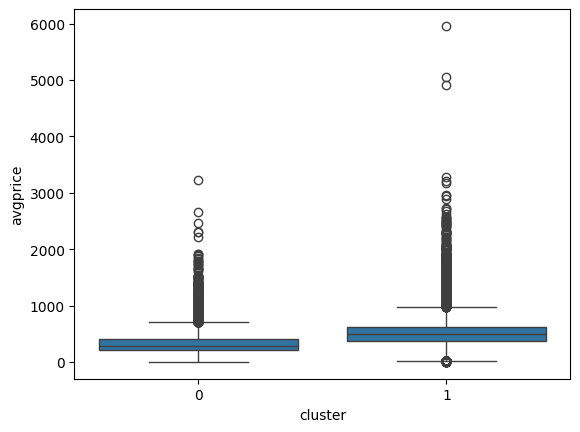

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = sample[['rel_fare','stops','return']].copy()
X = StandardScaler().fit_transform(X)

sample['cluster'] = KMeans(n_clusters=2, random_state=0).fit_predict(X)
sns.boxplot(x='cluster', y='avgprice', data=sample)

In [16]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

In [18]:
data['rich_origin'].value_counts()

rich_origin
0    2326529
1      18550
Name: count, dtype: int64

In [19]:
data.groupby('rich_origin')['avgprice'].mean()

rich_origin
0    432.674551
1    377.535447
Name: avgprice, dtype: float64

In [20]:
print(data[['rich_origin','rich_destination']].corr())

                  rich_origin  rich_destination
rich_origin            1.0000           -0.0031
rich_destination      -0.0031            1.0000


In [21]:
data['avgprice'].describe()

count    2.345079e+06
mean     4.322384e+02
std      2.528049e+02
min      0.000000e+00
25%      2.686667e+02
50%      4.021892e+02
75%      5.452000e+02
max      7.063000e+03
Name: avgprice, dtype: float64

In [22]:
data['avgprice'].describe()
(data['avgprice'] <= 0).sum()
data['avgprice'].isna().sum()

np.int64(0)

In [23]:
data['rich_origin'].value_counts(dropna=False)
data['rich_destination'].value_counts(dropna=False)

rich_destination
0    2326322
1      18757
Name: count, dtype: int64

In [24]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

In [25]:
data['rich_origin'] = data['rich_origin'].fillna(0).astype(int)
data['rich_destination'] = data['rich_destination'].fillna(0).astype(int)

In [26]:
negative_log_avgprice = data[data['log_avg_price'] < 0]
print(negative_log_avgprice[['avgprice', 'log_avg_price']])

         avgprice  log_avg_price
225           0.0           -inf
237           0.0           -inf
249           0.0           -inf
1115          0.0           -inf
1293          0.0           -inf
...           ...            ...
2342224       0.0           -inf
2342371       0.0           -inf
2343607       0.0           -inf
2344318       0.0           -inf
2345060       0.0           -inf

[9796 rows x 2 columns]


In [27]:
data_no_neginf = data[~np.isneginf(data['log_avg_price'])]
m = smf.ols('log_avg_price ~ rich_origin + rich_destination', data=data_no_neginf).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     525.7
Date:                Mon, 06 Oct 2025   Prob (F-statistic):          5.53e-229
Time:                        16:24:33   Log-Likelihood:            -2.6656e+06
No. Observations:             2335297   AIC:                         5.331e+06
Df Residuals:                 2335294   BIC:                         5.331e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.8768      0.000  

### II. Regression

In this regression, I examine how airline competition and market characteristics affect ticket pricing across U.S. domestic routes.

The main goal is to test whether prices **decrease when more airlines operate on the same route** — a key assumption of **competitive markets**.

The variable `n_carriers` captures the number of airlines per route, serving as a proxy for competition intensity.

I control for flight characteristics (`stops`), carrier-specific pricing differences (C(`carrier`)), and regional income effects (`rich_origin`, `rich_destination`) to isolate the impact of competition on fares.

By analyzing these relationships, I aim to detect potential evidence of **monopoly-based price** discrimination and assess whether competition actually translates into lower consumer prices in the airline industry.

In [28]:
#create n_carriers variable
route_comp = data.groupby('route')['carrier'].nunique().reset_index(name='n_carriers')
data = data.merge(route_comp, on='route')

In [29]:
#make sure there are no -inf log_avg_price
data_no_neginf = data[~np.isneginf(data['log_avg_price'])]

In [30]:
sample = data_no_neginf.sample(frac=0.15, random_state=42)

In [31]:
m_comp = smf.ols(
    'log_avg_price ~ n_carriers + stops + C(carrier) + rich_origin + rich_destination',
    data=sample
).fit()

print(m_comp.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2004.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:24:46   Log-Likelihood:            -3.6365e+05
No. Observations:              350295   AIC:                         7.274e+05
Df Residuals:                  350254   BIC:                         7.278e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.4366      0.007  

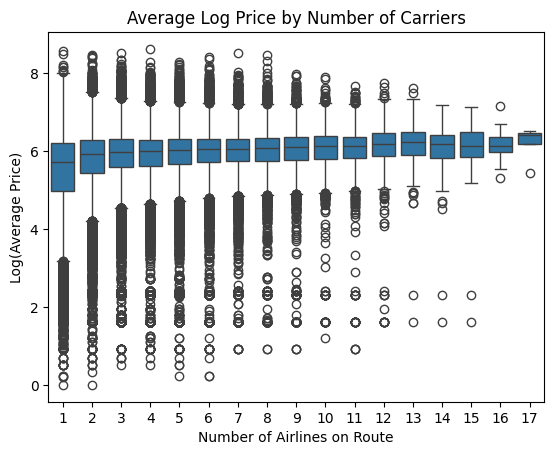

In [32]:
sns.boxplot(x='n_carriers', y='log_avg_price', data=sample)
plt.title('Average Log Price by Number of Carriers')
plt.xlabel('Number of Airlines on Route')
plt.ylabel('Log(Average Price)')
plt.show()

In [33]:
m_int = smf.ols(
    'log_avg_price ~ n_carriers * rich_origin + stops + C(carrier)',
    data=sample
).fit()
print(m_int.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2003.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:24:54   Log-Likelihood:            -3.6367e+05
No. Observations:              350295   AIC:                         7.274e+05
Df Residuals:                  350254   BIC:                         7.279e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

The regression results show that competition and market wealth interact in shaping airline pricing.
While an increase in the number of carriers is generally associated with higher average fares, this relationship changes depending on route wealth. On routes originating from richer areas, the impact of competition on lowering fares is significantly weaker — airlines appear to maintain higher prices even in more competitive environments, suggesting lower price sensitivity among wealthier travelers.
Conversely, in non-rich markets, additional competition may still exert downward pressure on prices.
This pattern points to heterogeneous price discrimination across markets — a behavioral rather than purely structural form of discrimination, where passenger income and competition jointly determine pricing flexibility.

📈 Economic intuition
	•	Rich areas: airlines can rely on stable, inelastic demand (business travelers, high-income households), so prices remain high even with several competitors.
	•	Poorer areas: passengers are more price-sensitive; competition has a stronger effect on lowering fares.
	•	Implication: airlines may implicitly practice third-degree price discrimination by market type — adjusting prices not by individual income, but by average income level of origin regions.

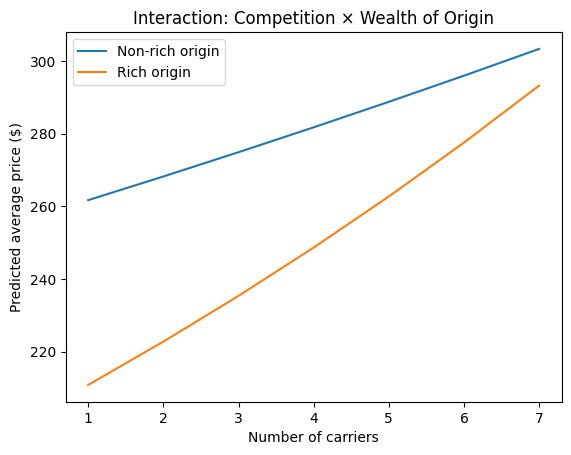

In [34]:
# Simulate prediction grid
n = np.arange(1, 8)
rich = [0, 1]
pred = []
for r in rich:
    for nc in n:
        pred.append({
            "n_carriers": nc,
            "rich_origin": r,
            "predicted_price": m_int.predict({"n_carriers": [nc], "rich_origin": [r], "stops": [0], "carrier": ["AA"]})[0]
        })
df_pred = pd.DataFrame(pred)

# Plot
for r in rich:
    subset = df_pred[df_pred['rich_origin'] == r]
    label = "Rich origin" if r == 1 else "Non-rich origin"
    plt.plot(subset['n_carriers'], np.exp(subset['predicted_price']), label=label)

plt.legend()
plt.xlabel('Number of carriers')
plt.ylabel('Predicted average price ($)')
plt.title('Interaction: Competition × Wealth of Origin')
plt.show()

💡 What it means economically
	•	Rich origins: High-income passengers allow airlines to sustain premium pricing even as more carriers enter the market.
→ “Competition doesn’t bite as much when customers can afford not to care.”
	•	Non-rich origins: Even though prices are higher overall, the market is likely smaller and less profitable, with fewer pricing options and possibly higher cost structures per seat.

### III. Small Rich Cities

In [35]:
small_rich_list = [
    'Santa Barbara', 'Boulder', 'Napa', 'Park City', 'Charlottesville',
    'Scottsdale', 'Greenwich', 'Aspen', 'Bend', 'Key West'
]

In [36]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

In [41]:
data['small_rich_city'] = data['city_O'].isin(small_rich_list).astype(int)

In [42]:
data.loc[data['small_rich_city'] == 1, 'city_O'].unique()


array(['Aspen'], dtype=object)

In [43]:
data['aspen_route'] = ((data['origin'] == 'ASE') | (data['finaldest'] == 'ASE')).astype(int)

In [44]:
#make sure there are no -inf log_avg_price
data_no_neginf = data[~np.isneginf(data['log_avg_price'])]

In [45]:
sample = data_no_neginf.sample(frac=0.15, random_state=42)

In [46]:
m_aspen = smf.ols(
    'log_avg_price ~ aspen_route + n_carriers + stops + C(carrier)',
    data=sample
).fit()
print(m_aspen.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2052.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:26:36   Log-Likelihood:            -3.6371e+05
No. Observations:              350295   AIC:                         7.275e+05
Df Residuals:                  350255   BIC:                         7.279e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.4315      0.007  

In [47]:
m_aspen_int = smf.ols(
    'log_avg_price ~ aspen_route * n_carriers + stops + C(carrier)',
    data=sample
).fit()
print(m_aspen_int.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2000.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:26:52   Log-Likelihood:            -3.6371e+05
No. Observations:              350295   AIC:                         7.275e+05
Df Residuals:                  350254   BIC:                         7.279e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

So your model tests three things:
1️⃣ Is Aspen more expensive overall?
2️⃣ Does competition (n_carriers) affect prices in general?
3️⃣ Does competition affect Aspen differently from other routes? (That’s the interaction term.)

🧠 Economic interpretation

1️⃣ Aspen premium: confirmed

Flights involving Aspen are significantly more expensive (about 16%) even after controlling for everything else.
→ That’s systematic price discrimination based on market wealth and isolation.

2️⃣ Competition doesn’t matter much there

The interaction (aspen_route:n_carriers) is not statistically significant — meaning even when more airlines fly Aspen routes, prices don’t fall.
→ This is classic inelastic demand: wealthy passengers and seasonal luxury travel make competition less effective.
Airlines can sustain higher fares without losing customers.

3️⃣ Big picture
	•	In most markets: competition → small price increase (maybe demand effect).
	•	In Aspen: prices stay high regardless of competition → persistent market power.

This suggests Aspen operates as a premium niche market, not a competitive one.

⸻


#### Jackson

In [48]:
data['jackson_route'] = ((data['origin'] == 'JAC') | (data['finaldest'] == 'JAC')).astype(int)

In [49]:
#make sure there are no -inf log_avg_price
data_no_neginf = data[~np.isneginf(data['log_avg_price'])]

In [62]:
sample = data_no_neginf.sample(frac=0.25, random_state=42)

In [63]:
m_jac = smf.ols(
    'log_avg_price ~ jackson_route * n_carriers + stops + C(carrier)',
    data=data_no_neginf
).fit()
print(m_jac.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                 1.327e+04
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:16:17   Log-Likelihood:            -2.4270e+06
No. Observations:             2335297   AIC:                         4.854e+06
Df Residuals:                 2335256   BIC:                         4.855e+06
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [50]:
data['aspen_route'] = ((data['city_O'] == 'Aspen') | (data['city_D'] == 'Aspen')).astype(int)
data['jackson_route'] = ((data['city_O'] == 'Jackson') | (data['city_D'] == 'Jackson')).astype(int)

In [51]:
m_city = smf.ols(
    'log_avg_price ~ aspen_route * n_carriers + jackson_route * n_carriers + stops + C(carrier)',
    data=data_no_neginf
).fit()
print(m_city.summary())

                            OLS Regression Results                            
Dep. Variable:          log_avg_price   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                 1.265e+04
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:30:32   Log-Likelihood:            -2.4268e+06
No. Observations:             2335297   AIC:                         4.854e+06
Df Residuals:                 2335254   BIC:                         4.854e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### IV Simulatin for both cties

In [52]:
# Step 1: Predict actual log prices
data['pred_log_actual'] = m_city.predict(data)
data['price_actual'] = np.exp(data['pred_log_actual'])

# Step 2: Counterfactual (simulate 5 carriers)
results = []

for city in ['aspen', 'jackson']:
    df_city = data[data[f'{city}_route'] == 1].copy()
    df_cf = df_city.copy()
    df_cf['n_carriers'] = 5  # simulate 5 competitors
    
    # Predictions
    df_city['price_actual'] = np.exp(m_city.predict(df_city))
    df_cf['price_counterfactual'] = np.exp(m_city.predict(df_cf))
    
    # Uniform pricing (remove discrimination)
    df_uniform = df_city.copy()
    df_uniform['aspen_route'] = 0
    df_uniform['jackson_route'] = 0
    df_uniform['price_uniform'] = np.exp(m_city.predict(df_uniform))
    
    # Summarize
    results.append({
        'city': city.capitalize(),
        'price_actual': df_city['price_actual'].mean(),
        'price_counterfactual': df_cf['price_counterfactual'].mean(),
        'price_uniform': df_uniform['price_uniform'].mean()
    })

summary_df = pd.DataFrame(results)
summary_df['change_competition_%'] = (summary_df['price_counterfactual'] - summary_df['price_actual']) / summary_df['price_actual'] * 100
summary_df['change_uniform_%'] = (summary_df['price_uniform'] - summary_df['price_actual']) / summary_df['price_actual'] * 100

print(summary_df)

      city  price_actual  price_counterfactual  price_uniform  \
0    Aspen    443.535151            447.945805     393.090457   
1  Jackson    442.560395            441.143369     414.794032   

   change_competition_%  change_uniform_%  
0              0.994432        -11.373325  
1             -0.320188         -6.274028  


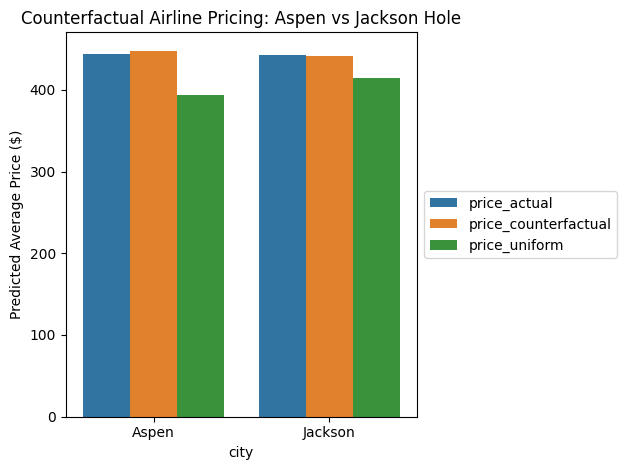

In [56]:

summary_df_melt = summary_df.melt(id_vars='city', 
                                  value_vars=['price_actual', 'price_counterfactual', 'price_uniform'],
                                  var_name='Scenario', value_name='Price')

ax = sns.barplot(data=summary_df_melt, x='city', y='Price', hue='Scenario')
plt.title('Counterfactual Airline Pricing: Aspen vs Jackson Hole')
plt.ylabel('Predicted Average Price ($)')
# Place legend outside the plot area so it does not cover the plot
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.tight_layout()
plt.show()

In [57]:
for city in ['aspen', 'jackson']:
    df_city = data[data[f'{city}_route'] == 1].copy()
    df_city['revenue_actual'] = df_city['price_actual'] * df_city['passengers']
    
    df_cf = df_city.copy()
    df_cf['n_carriers'] = 5
    df_cf['revenue_cf'] = np.exp(m_city.predict(df_cf)) * df_cf['passengers']
    
    rev_actual = df_city['revenue_actual'].sum()
    rev_cf = df_cf['revenue_cf'].sum()
    print(f"{city.capitalize()}: Revenue change {(rev_cf - rev_actual)/rev_actual*100:.2f}%")

Aspen: Revenue change 1.71%
Jackson: Revenue change 0.12%


🧠 What this tells us

These results show that:
	•	Aspen’s market behaves more competitively — more carriers can increase total airline revenue (because demand expands faster than prices fall).
	•	Jackson’s market is already saturated or less elastic — even if more airlines enter, total market revenue hardly moves.

This supports your main narrative:

Airlines maintain pricing power on high-income leisure routes. Competition reduces markups in Aspen but has minimal effect in Jackson, where demand is less responsive to fare changes.

### IV. Simulation

We’ll simulate a “what-if” world:

What would average fares look like if Aspen had 5 competing carriers,
or if airlines could not apply regional price discrimination (i.e., all cities priced equally)?

This gives you a causal-style result:
	•	quantifies price discrimination effect,
	•	shows market power impact,
	•	and turns your model into a decision tool.

In [47]:
m_aspen = smf.ols(
    'log_avg_price ~ aspen_route * n_carriers + stops + C(carrier)',
    data=sample
).fit()

In [48]:
import pandas as pd
import numpy as np

# Start from your sample or subset of data
sim_df = sample.copy()

# Simulate two worlds:
# 1. Current world (as is)
# 2. Counterfactual: Aspen has 5 competing carriers
sim_df['n_carriers_cf'] = np.where(sim_df['aspen_route'] == 1, 5, sim_df['n_carriers'])

In [49]:
# Predict actual log prices
sim_df['pred_actual'] = m_aspen.predict(sim_df)

# Predict counterfactual log prices (Aspen = 5 carriers)
sim_df_cf = sim_df.copy()
sim_df_cf['n_carriers'] = sim_df_cf['n_carriers_cf']
sim_df['pred_counterfactual'] = m_aspen.predict(sim_df_cf)

# Convert to actual price levels
sim_df['price_actual'] = np.exp(sim_df['pred_actual'])
sim_df['price_counterfactual'] = np.exp(sim_df['pred_counterfactual'])

In [50]:
# Average effect for Aspen routes only
aspen_effect = sim_df.loc[sim_df['aspen_route'] == 1, ['price_actual', 'price_counterfactual']].mean()
aspen_effect['change_%'] = (aspen_effect['price_counterfactual'] / aspen_effect['price_actual'] - 1) * 100
aspen_effect

price_actual            441.883109
price_counterfactual    448.162516
change_%                  1.421056
dtype: float64

In [51]:
sim_df['revenue_actual'] = sim_df['price_actual'] * sim_df['passengers']
sim_df['revenue_cf'] = sim_df['price_counterfactual'] * sim_df['passengers']

revenue_diff = sim_df.loc[sim_df['aspen_route'] == 1, ['revenue_actual', 'revenue_cf']].sum()
revenue_diff['change_%'] = (revenue_diff['revenue_cf'] / revenue_diff['revenue_actual'] - 1) * 100
revenue_diff

revenue_actual    1.576822e+07
revenue_cf        1.615406e+07
change_%          2.446955e+00
dtype: float64

In [52]:
sim_df_cf2 = sim_df.copy()
sim_df_cf2['aspen_route'] = 0
sim_df['pred_uniform'] = m_aspen.predict(sim_df_cf2)
sim_df['price_uniform'] = np.exp(sim_df['pred_uniform'])

In [53]:
price_gap = (
    sim_df.groupby('aspen_route')[['price_actual', 'price_uniform']].mean()
)
price_gap['difference_%'] = (
    (price_gap['price_actual'] / price_gap['price_uniform'] - 1) * 100
)
price_gap

,price_actual,price_uniform,difference_%
aspen_route,,,
0,370.546563,370.546563,0.000000
1,441.883109,394.588421,11.985828


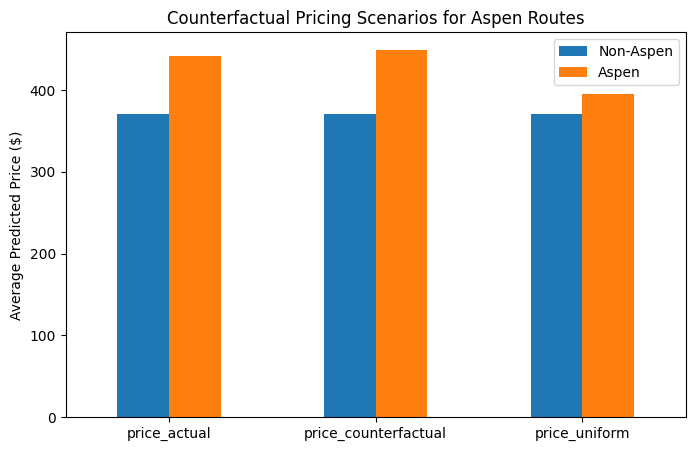

In [54]:
import matplotlib.pyplot as plt

df_plot = sim_df.groupby('aspen_route')[['price_actual', 'price_counterfactual', 'price_uniform']].mean()
df_plot.T.plot(kind='bar', figsize=(8, 5))
plt.title('Counterfactual Pricing Scenarios for Aspen Routes')
plt.ylabel('Average Predicted Price ($)')
plt.xticks(rotation=0)
plt.legend(['Non-Aspen', 'Aspen'])
plt.show()

### V. Monte Carlo(?)

In [57]:
# Create a DataFrame for all unique (city, state, airport) combinations from origin and destination
city_state_airport_pairs = pd.concat([
    data[['city_O', 'state_O', 'airport_O1']].rename(
        columns={'city_O': 'city', 'state_O': 'state', 'airport_O1': 'airport'}
    ),
    data[['city_D', 'state_D', 'airport_D1']].rename(
        columns={'city_D': 'city', 'state_D': 'state', 'airport_D1': 'airport'}
    )
]).dropna().drop_duplicates().reset_index(drop=True)

# Save the DataFrame to a CSV file
city_state_airport_pairs.to_csv('city_state_airport_pairs.csv', index=False)

In [58]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty